In [45]:
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.utils import k_hop_subgraph
import torch_geometric
import os
import numpy as np
import torch
from torch.distributions.distribution import Distribution
from scipy.stats import gaussian_kde
import tqdm
from KDEpy import FFTKDE
from torch_sparse import spspmm
from torch_scatter import scatter_add,scatter_sum
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import pickle

# PlogP

In [3]:
def get_PlogP(
                DataName=['DD','PROTEINS','NCI1','NCI109','Mutagenicity','ENZYMES'],
                N_feature=[89,4,37,38,14,21],
                batch_size=32
            ):
    '''
    ['DD','PROTEINS','NCI1','NCI109','Mutagenicity','ENZYMES']
    '''
    PlogP_dataset={dataname:None for dataname in DataName}
    
    for i in range(len(DataName)):
        dataset = TUDataset(os.path.join('data',DataName[i]), name=DataName[i], use_node_attr=True)
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        X,edge_index,node_batch,edge_batch=[],[],[],[]
        for b,data in enumerate(train_loader):
            X.append(data.x)
            edge_index.append(data.edge_index)
            node_batch.append(torch.zeros(data.x.shape[0])+b)
            edge_batch.append(torch.zeros(data.edge_index.shape[1])+b)
        X=torch.vstack(X)
        edge_index=torch.hstack(edge_index)
        node_batch=torch.hstack(node_batch)
        edge_batch=torch.hstack(edge_batch)
        
        PlogP_all=None
        use_channel=[]
        for channel in tqdm.tqdm(range(N_feature[i])):
            x=X[:,channel]
            if torch.unique(x).shape[0]==1:
                continue
            use_channel.append(channel)
            P=estimate_P(x,x)
            PlogP=P*np.log2(P)
            PlogP=torch.tensor(PlogP.reshape(-1,1))
            PlogP_all
            if PlogP_all is None:
                PlogP_all=PlogP
            else:
                PlogP_all=torch.hstack([PlogP_all,PlogP])
                
        PlogP_all[PlogP_all.isnan()]=0
        PlogP_dataset[DataName[i]]=(PlogP_all,edge_index,node_batch,edge_batch,use_channel)
    return PlogP_dataset

def estimate_P(support,x):
    kde0=gaussian_kde(support,bw_method='silverman') # silverman  scott
    value,freq=np.unique(support,return_counts=True)
    kde=gaussian_kde(value,bw_method=kde0.factor,weights=freq)
    P=kde(x)
    return P

In [4]:
if not os.path.exists('PlogP_dataset.pkl'):
    PlogP_dataset=get_PlogP()
    pickle.dump(PlogP_dataset, open('PlogP_dataset.pkl', 'wb'))
else:
    PlogP_dataset=pickle.load(open('PlogP_dataset.pkl', 'rb'))

# entropy

In [5]:
from torch_geometric.nn.conv import MessagePassing
class GCN(MessagePassing):
    def __init__(self):
        super(GCN, self).__init__(aggr='add')
        pass

    def forward(self, x_row, edge_index_row,node_batch,edge_batch,k):
        node_batch,edge_batch=node_batch.to(x_row.device),edge_batch.to(x_row.device)
        Batch=torch.unique(node_batch)
        entropy=None
        for B in Batch:
            mask_node=(node_batch==B)
            mask_edge=(edge_batch==B)
            x=x_row[mask_node]
            edge_index=edge_index_row[:,mask_edge]
            
            n,c_in=x.shape
            edge_index_raw=edge_index
            for i in range(0,k-1):
                edge_index,_=spspmm(edge_index,None,edge_index_raw,None,n,n,n)
            value = edge_index.new_ones((edge_index.size(1),), dtype=torch.float,device=x_row.device)
            self.deg = scatter_add(value, edge_index[0], dim=0, dim_size=n)

            entropy_new=-self.propagate(edge_index, x=x, norm=None)
            entropy_new=entropy_new.view(-1,c_in).cpu().numpy()
            
            if entropy is None:
                entropy=entropy_new
            else:
                entropy=np.vstack([entropy,entropy_new])
        return entropy

    def message(self, x_j, norm):
        return  x_j

    def update(self, aggr_out):
        return aggr_out/(self.deg.view(-1,1)+1e-10)

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

In [6]:
device=[5]
def get_entropy(PlogP_dataset):
    '''
    ['DD','PROTEINS','NCI1','NCI109','Mutagenicity','ENZYMES']
    '''
    gcn=GCN().to(device[0])
    DataName=['DD','PROTEINS','NCI1','NCI109','Mutagenicity','ENZYMES']
    
    entropy_all={dataname:[] for dataname in DataName}
    with torch.no_grad():
        for i in range(len(DataName)):
            PlogP,edge_index,node_batch,edge_batch,_=PlogP_dataset[DataName[i]]
            PlogP,edge_index = PlogP.to(device[0]),edge_index.to(device[0])
            for k in tqdm.tqdm(range(1,10)):
                entropy=gcn(PlogP,edge_index,node_batch,edge_batch,k=k)
                entropy_all[DataName[i]].append(entropy)
            del PlogP
            del edge_index
    return entropy_all

In [7]:
if not os.path.exists('entropy_all.pkl'):
    entropy_all=get_entropy(PlogP_dataset)
    pickle.dump(entropy_all, open('entropy_all.pkl', 'wb'))
else:
    entropy_all=pickle.load(open('entropy_all.pkl', 'rb'))

# plot

In [13]:
for dataname in ['DD','PROTEINS','NCI1','NCI109','Mutagenicity','ENZYMES']:
    for k in tqdm.tqdm(range(9)):
        entropy=entropy_all[dataname][k]
        for channel in range(entropy.shape[1]):
            value_support=entropy[:,channel]#[entropy[:,channel]>=0]
            x_anchor=np.linspace(value_support.min(),value_support.max(),1000)
            P = estimate_P(value_support,x_anchor)
            plt.scatter(x_anchor,P)
            plt.savefig('./figs/{}_{}_{}.png'.format(dataname,channel,k+1))
            plt.close()

100%|██████████| 9/9 [01:18<00:00,  8.76s/it]


# entropy diff

In [ ]:
anchor==np.linspace(value_support.min(),value_support.max(),1000)

In [26]:
entropy_DD=np.array(entropy_all['DD'])

In [29]:
entropy_DD[:,:,0].min()

-17.89591923667804

In [30]:
entropy_DD[:,:,0].max()

0.440636571638177

In [ ]:
entropy_all['DD'][1][:,0]

In [ ]:
scipy.stats.entropy()

# $H(X_c(i)|k)$

- input: $ G(X,E), k $
- output: $ H(c|k) $ for all $c$

## estimate P

In [5]:
def estimate_P(support,x):
    kde0=gaussian_kde(support,bw_method='silverman') # silverman  scott
    value,freq=np.unique(support,return_counts=True)
    kde=gaussian_kde(value,bw_method=kde0.factor,weights=freq)
    P=kde(x)
    return P

def get_P(
                DataName=['DD','PROTEINS','NCI1','NCI109','Mutagenicity','ENZYMES'],
                N_feature=[89,4,37,38,14,21],
                batch_size=32
            ):
    '''
    ['DD','PROTEINS','NCI1','NCI109','Mutagenicity','ENZYMES']
    '''
    P_dataset={dataname:None for dataname in DataName}
    
    for i in range(len(DataName)):
        dataset = TUDataset(os.path.join('data',DataName[i]), name=DataName[i], use_node_attr=True)
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        X,edge_index,node_batch,edge_batch=[],[],[],[]
        for b,data in enumerate(train_loader):
            X.append(data.x)
            edge_index.append(data.edge_index)
            node_batch.append(torch.zeros(data.x.shape[0])+b)
            edge_batch.append(torch.zeros(data.edge_index.shape[1])+b)
        X=torch.vstack(X)
        edge_index=torch.hstack(edge_index)
        node_batch=torch.hstack(node_batch)
        edge_batch=torch.hstack(edge_batch)
        
        P_all=None
        use_channel=[]
        for channel in tqdm.tqdm(range(N_feature[i])):
            x=X[:,channel]
            if torch.unique(x).shape[0]==1:
                continue
            use_channel.append(channel)
            P=estimate_P(x,x)
            P=torch.tensor(P.reshape(-1,1))
            if P_all is None:
                P_all=P
            else:
                P_all=torch.hstack([P_all,P])
                
        P_all[P_all.isnan()]=0
        P_dataset[DataName[i]]=(P_all,edge_index,node_batch,edge_batch,use_channel)
    return P_dataset

In [6]:
if not os.path.exists('P_dataset.pkl'):
    P_dataset=get_P()
    pickle.dump(P_dataset, open('P_dataset.pkl', 'wb'))
else:
    P_dataset=pickle.load(open('P_dataset.pkl', 'rb'))

100%|██████████| 21/21 [00:14<00:00,  1.46it/s]


## entropy

In [46]:
import torch
import torch.nn as nn
from scipy.stats import gaussian_kde
import numpy as np

In [59]:
from torch_geometric.nn.conv import MessagePassing

class EntropyGCN(MessagePassing):
    def __init__(self,normalize=True):
        super(EntropyGCN, self).__init__(aggr='add')
        self.normalize=normalize

    def forward(self, P, edge_index,k):
        n,c_in=P.shape
        edge_index_raw=edge_index
        for i in range(0,k-1):
            edge_index,_=spspmm(edge_index,None,edge_index_raw,None,n,n,n)


        P_local_sum=scatter_sum(P[edge_index[0]],edge_index[1],dim=0)
        P_hat=P[edge_index[0]]/P_local_sum[edge_index[1]]
        entropy=-scatter_sum(P_hat*torch.log(P_hat),edge_index[1],dim=0)
        return entropy

    def message(self, x_j, norm):
        # x_j: [E,out_channels] (46042,82)
        # norm: [E,out_channels] (46042,82)
        if norm is None:
            return x_j
        else:
            return  x_j*norm

    def update(self, aggr_out):
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)


class Bacth_GCN(nn.Module):
    def __init__(self):
        super(Bacth_GCN,self).__init__()
        self.gcn=EntropyGCN()
    
    def forward(self,P,edge_index,node_batch,edge_batch,k):
        node_batch,edge_batch=node_batch.to(P.device),edge_batch.to(P.device)
        Batch=torch.unique(node_batch)
        Entropy_all=None
        for B in Batch:
            mask_node=(node_batch==B)
            mask_edge=(edge_batch==B)
            P0=P[mask_node]
            edge_index0=edge_index[:,mask_edge]
            
            Entropy=self.gcn(P0,edge_index0,k)
            
            if Entropy_all is None:
                Entropy_all=Entropy
            else:
                Entropy_all=torch.vstack([Entropy_all,Entropy])
        
        return Entropy_all


device=[5]
def get_entropy(P_dataset):
    '''
    ['DD','PROTEINS','NCI1','NCI109','Mutagenicity','ENZYMES']
    '''
    bgcn=Bacth_GCN().to(device[0])
    DataName=['DD','PROTEINS','NCI1','NCI109','Mutagenicity','ENZYMES']
    
    entropy_all={dataname:[] for dataname in DataName}
    with torch.no_grad():
        for i in range(len(DataName)):
            P,edge_index,node_batch,edge_batch,_=P_dataset[DataName[i]]
            P,edge_index = P.to(device[0]),edge_index.to(device[0])
            for k in tqdm.tqdm(range(1,10)):
                entropy=bgcn(P,edge_index,node_batch,edge_batch,k=k)
                entropy_all[DataName[i]].append(entropy)
            del P
            del edge_index
    return entropy_all

In [61]:
if not os.path.exists('entropy_all.pkl'):
    entropy_all=get_entropy(P_dataset)
    pickle.dump(entropy_all, open('entropy_all.pkl', 'wb'))
else:
    entropy_all=pickle.load(open('entropy_all.pkl', 'rb'))

100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


## visualize entropy

In [67]:
for dataname in ['DD','PROTEINS','NCI1','NCI109','Mutagenicity','ENZYMES']:
    for k in tqdm.tqdm(range(9)):
        entropy=entropy_all[dataname][k].cpu()
        for channel in range(entropy.shape[1]):
            value_support=entropy[:,channel]#[entropy[:,channel]>=0]
            x_anchor=np.linspace(value_support.min(),value_support.max(),1000)
            P = estimate_P(value_support,x_anchor)
            plt.scatter(x_anchor,P)
            plt.savefig('./figs/{}_{}_{}.png'.format(dataname,channel,k+1))
            plt.close()

100%|██████████| 9/9 [01:50<00:00, 12.26s/it]


## entropy diff

In [73]:
x1=entropy_all['DD'][0][:,0].cpu().numpy()
x2=entropy_all['DD'][0][:,1].cpu().numpy()

In [120]:
def EntropyDiff_Channel(x1,x2):
    x_min=min(np.min(x1),np.min(x2))
    x_max=max(np.max(x1),np.max(x2))

    anchor=np.linspace(x_min,x_max,1000)
    delta=(x_max-x_min)/1000
    
    P1=estimate_P(x1,anchor)
    P2=estimate_P(x2,anchor)
    KL=np.sum(delta*P2*np.log((P2+1e-15)/(P1+1e-15)))
    return KL

def EntropyDiff_MeanChannels(X1,X2):
    entropys=[]
    for i in range(X1.shape[1]):
        x1=X1[:,i]
        x2=X2[:,i]
        entropys.append(EntropyDiff_Channel(x1,x2))
    return np.mean(entropys)

def EntropyDiff_Dataset(dataname):
    dataset=entropy_all[dataname]
    entropy_diffs=[]
    for i in tqdm.tqdm(range(0,8)):
        X1=dataset[i].cpu().numpy()
        X2=dataset[i+1].cpu().numpy()
        entropy_diff=EntropyDiff_MeanChannels(X1,X2)
        entropy_diffs.append(entropy_diff)
    return entropy_diffs

In [121]:
def get_EntropyDiffs():
    entropy_diffs_DD=EntropyDiff_Dataset('DD')
    entropy_diffs_PROTEINS=EntropyDiff_Dataset('PROTEINS')
    entropy_diffs_NCI1=EntropyDiff_Dataset('NCI1')
    entropy_diffs_NCI109=EntropyDiff_Dataset('NCI109')
    entropy_diffs_Mutagenicity=EntropyDiff_Dataset('Mutagenicity')
    entropy_diffs_ENZYMES=EntropyDiff_Dataset('ENZYMES')

    entropy_diffs={}
    entropy_diffs['DD']=entropy_diffs_DD
    entropy_diffs['PROTEINS']=entropy_diffs_PROTEINS
    entropy_diffs['NCI1']=entropy_diffs_NCI1
    entropy_diffs['NCI109']=entropy_diffs_NCI109
    entropy_diffs['Mutagenicity']=entropy_diffs_Mutagenicity
    entropy_diffs['ENZYMES']=entropy_diffs_ENZYMES
    return entropy_diffs

In [122]:
if not os.path.exists('entropy_diffs.pkl'):
    entropy_diffs=get_EntropyDiffs()
    pickle.dump(entropy_diffs, open('entropy_diffs.pkl', 'wb'))
else:
    entropy_diffs=pickle.load(open('entropy_diffs.pkl', 'rb'))

100%|██████████| 8/8 [01:51<00:00, 13.97s/it]


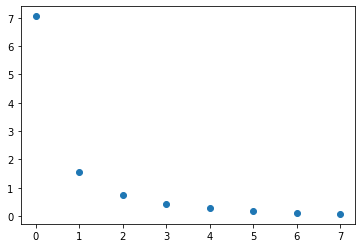

In [123]:
plt.scatter(range(0,8),entropy_diffs['DD'])

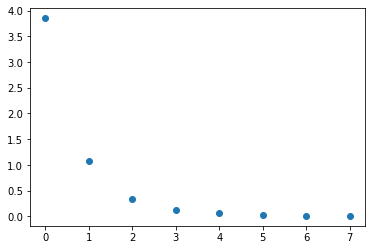

In [124]:
plt.scatter(range(0,8),entropy_diffs['PROTEINS'])

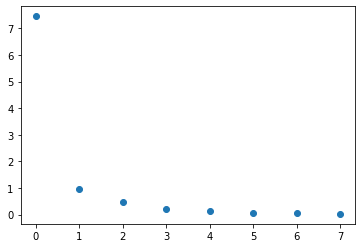

In [125]:
plt.scatter(range(0,8),entropy_diffs['NCI1'])

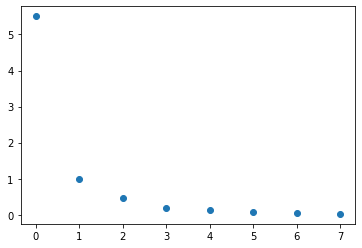

In [126]:
plt.scatter(range(0,8),entropy_diffs['NCI109'])

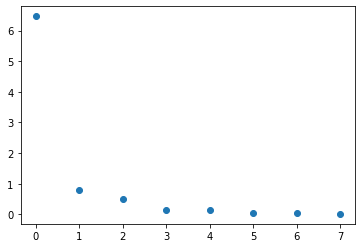

In [127]:
plt.scatter(range(0,8),entropy_diffs['Mutagenicity'])

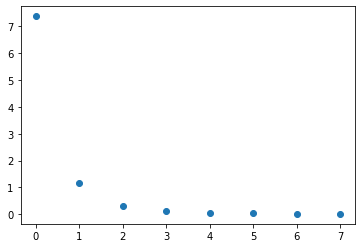

In [128]:
plt.scatter(range(0,8),entropy_diffs['ENZYMES'])

# Protein

In [160]:
dataset = TUDataset(os.path.join('data', 'PROTEINS'), name='PROTEINS', use_node_attr=True)
train_loader = DataLoader(dataset, batch_size=int(np.sum(dataset.data.num_nodes)), shuffle=True)
for data in train_loader:
    break

X,edge_index=data.x,data.edge_index
kdes=[gaussian_kde(X[:,i],bw_method='silverman') for i in range(X.shape[1])]

In [163]:
n = X.shape[0]
value = edge_index.new_ones((edge_index.size(1),), dtype=torch.float)
deg = scatter_add(value, edge_index[0], dim=0, dim_size=n)

P=kdes[1](X[:,1])
PlogP=P*np.log2(P)
PlogP=torch.tensor(PlogP.reshape(-1,1))

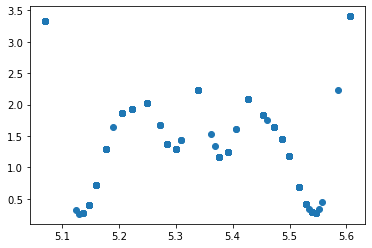

In [164]:
entropy,P=gcn(PlogP,edge_index,k=1)
plt.scatter(entropy,P)

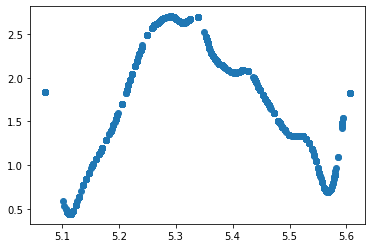

In [165]:
entropy,P=gcn(PlogP,edge_index,k=2)
plt.scatter(entropy,P)

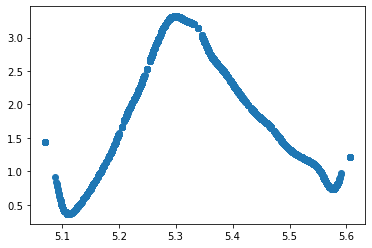

In [166]:
entropy,P=gcn(PlogP,edge_index,k=3)
plt.scatter(entropy,P)

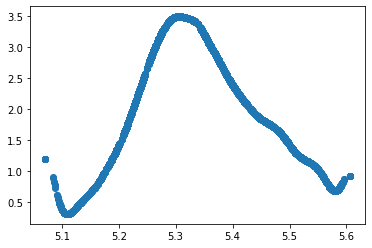

In [167]:
entropy,P=gcn(PlogP,edge_index,k=4)
plt.scatter(entropy,P)

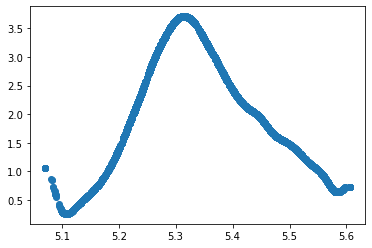

In [168]:
entropy,P=gcn(PlogP,edge_index,k=5)
plt.scatter(entropy,P)

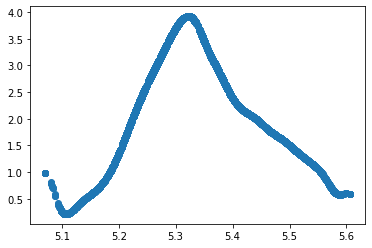

In [169]:
entropy,P=gcn(PlogP,edge_index,k=6)
plt.scatter(entropy,P)